# Wrangling Candy Data

<img src="candy.jpg">

# Background

The Science Creative Quarterly posted data (http://www.scq.ubc.ca/so-much-candy-data-seriously/) collected from an online survey about candy preferences that it has conducted each year since 2014. The survey included 103 questions which asked the respondent to rank types of candy, and 17 additional questions such as age and location. I focused on the 2017 survey data, for which there were 2460 respondents.

In [60]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [61]:
#import candy data csv

candy17 = pd.read_csv('candyhierarchy2017.csv', encoding = "ISO-8859-1", sep = ',')

# Inspect Data

In [141]:
#check out the first few lines of data

candy17.head()

,Internal ID,Q1: GOING OUT?,Q2: GENDER,Q3: AGE,Q4: COUNTRY,"Q5: STATE, PROVINCE, COUNTY, ETC",Q6 | 100 Grand Bar,Q6 | Anonymous brown globs that come in black and orange wrappers (a.k.a. Mary Janes),Q6 | Any full-sized candy bar,Q6 | Black Jacks,...,Q12: MEDIA [ESPN],Q12: MEDIA [Yahoo],"Click Coordinates (x, y)",Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126
0,90258773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90272821,No,Male,44,USA,NM,MEH,DESPAIR,JOY,MEH,...,NaN,NaN,"(84, 25)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90272829,NaN,Male,49,USA,Virginia,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90272840,No,Male,40,us,or,MEH,DESPAIR,JOY,MEH,...,NaN,NaN,"(75, 23)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90272841,No,Male,23,usa,exton pa,JOY,DESPAIR,JOY,DESPAIR,...,NaN,NaN,"(70, 10)",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# look at the number of entries and columns, as well as data types

candy17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Columns: 127 entries, Internal ID to Unnamed: 126
dtypes: float64(2), int64(1), object(124)
memory usage: 2.4+ MB


# Assess and Address Data Cleaning Issues

## Issue 1: divide data into two tables: candy ratings and other questions

There are currently 127 columns in the dataframe, most of which are candy-related questions (those with the prefix 'Q6') and others of which are demographic and other non-candy-related questions. It will make the data easier to manage if it is in two tables linked by the Internal ID column (i.e. the unique ID for each instance of the survey). 

In [64]:
cols = candy17.columns

In [65]:
#find all column names that pertain to candy-related questions

candy_cols = [c for c in cols if 'Q6' in c]

#find all column names that pertain to non-candy-related questions

other_cols = [q for q in cols if 'Q6' not in q]

In [66]:
#Create table: candy_questions

candy_questions = candy17[candy_cols]

In [67]:
#Create table: other_questions

other_questions = candy17[other_cols]

In [68]:
#Copy ID column to the candy_questions table to link the two tables
candy_questions['Internal ID'] = candy17['Internal ID']

## Issue 2: clean up the column names

The column names are long and will be difficult to reference in their current state, since some contain the question number followed by a colon (e.g. 'Q3: AGE') and others are followed by a pipe symbol (e.g. 'Q6 | 100 Grand Bar'). We don't need the question numbers or their punctuation, so let's get rid of them.

In [69]:
# replace all strings that start with 'Q', are followed by one or more number, and end with 
# a symbol

candy_questions.columns = candy_questions.columns.str.replace('Q[0-9]+\W+', '')

In [70]:
# check the column names to see if that fixed it

candy_questions.columns

Index(['100 Grand Bar',
       'Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes)',
       'Any full-sized candy bar', 'Black Jacks', 'Bonkers (the candy)',
       'Bonkers (the board game)', 'Bottle Caps', 'Box'o'Raisins',
       'Broken glow stick', 'Butterfinger',
       ...
       'Tolberone something or other', 'Trail Mix', 'Twix',
       'Vials of pure high fructose corn syrup, for main-lining into your vein',
       'Vicodin', 'Whatchamacallit Bars', 'White Bread',
       'Whole Wheat anything', 'York Peppermint Patties', 'Internal ID'],
      dtype='object', length=104)

In [71]:
# Do the same for the other table

other_questions.columns = other_questions.columns.str.replace('Q[0-9]+\W+', '')

In [72]:
other_questions.columns

Index(['Internal ID', 'GOING OUT?', 'GENDER', 'AGE', 'COUNTRY',
       'STATE, PROVINCE, COUNTY, ETC', 'JOY OTHER', 'DESPAIR OTHER',
       'OTHER COMMENTS', 'DRESS', 'Unnamed: 113', 'DAY', 'MEDIA [Daily Dish]',
       'MEDIA [Science]', 'MEDIA [ESPN]', 'MEDIA [Yahoo]',
       'Click Coordinates (x, y)', 'Unnamed: 120', 'Unnamed: 121',
       'Unnamed: 122', 'Unnamed: 123', 'Unnamed: 124', 'Unnamed: 125',
       'Unnamed: 126'],
      dtype='object')

## Issue 3: Inconsistent and non-valid values in some columns

### Issue 3a: 

There are some stray values in the MEDIA columns. These questions pertained to a choice of four images, and respondents were instructed to pick one. These columns should only contain '1' if the person clicked on that image, and NaN if they did not.

In [73]:
# Some examples of values that do not belong in the MEDIA columns

other_questions['MEDIA [Daily Dish]'].value_counts()

1                                                                                                 85
Friday                                                                                             6
Sunday                                                                                             2
 nail clippings                                                                                    1
Candy corn gets a bad rap. I like it but original flavor only, fresh, and in very small doses.     1
 the ending of season 3 twin peaks                                                                 1
 corn nuts                                                                                         1
Name: MEDIA [Daily Dish], dtype: int64

In [74]:
# Write a function that converts values that are not equal to 1 to NaN

def convert_nan(value):
    if value == "1":       # "1" because 1 is a string in the columns we want to change
        return 1
    elif value == np.nan:
        return np.nan
    else:
        return np.nan

In [75]:
# Apply the convert_nan function to all the MEDIA columns

other_questions.loc[:, 'MEDIA [Daily Dish]':'MEDIA [Yahoo]'] = other_questions.loc[:, 'MEDIA [Daily Dish]':'MEDIA [Yahoo]'].applymap(convert_nan)

In [76]:
# Check the value counts in some of the MEDIA columns to make sure all stray values were 
# converted to Nan

other_questions['MEDIA [Daily Dish]'].value_counts()

1.0    85
Name: MEDIA [Daily Dish], dtype: int64

In [77]:
other_questions['MEDIA [Science]'].value_counts()

1.0    1350
Name: MEDIA [Science], dtype: int64

### Issue 3b: 

Country names need to be standardized. There are currently several values that have multiple names for the same place (e.g. 'USA' and 'United States'; 'UK' and 'United Kingdom') and differences in capitalization cause problems (e.g. 'Canada' vs. 'canada').

In [78]:
print(other_questions['COUNTRY'].value_counts().nlargest(10))

USA                         699
United States               497
usa                         217
Canada                      179
Usa                         139
US                          126
USA                          73
United States of America     57
us                           40
united states                38
Name: COUNTRY, dtype: int64


In [79]:
# Convert all country names to lowercase to avoid differences in capitalization 

other_questions.COUNTRY = other_questions.COUNTRY.str.lower()

In [80]:
# Change all instances referring to the US, America, etc. to 'united states'

other_questions.COUNTRY = other_questions['COUNTRY'].str.replace('(us|us|united states of america|america|u.s.|united states|unites states)', 
                                                                'united states')

In [81]:
# Catch any other instances and convert to 'united states'

other_questions.COUNTRY = other_questions['COUNTRY'].str.replace('(united statesa|united states.)', 'united states') 

In [82]:
# Convert Nans in COUNTRY column to 'none' in order to iterate over column

other_questions.COUNTRY = other_questions.COUNTRY.fillna('none')

In [83]:
other_questions.COUNTRY.value_counts().nlargest(10)

united states          1926
canada                  215
united states            74
none                     64
uk                       17
united kingdom           14
germany                  10
canada                    9
united states.            8
aunited statesralia       7
Name: COUNTRY, dtype: int64

In [84]:
# There are still some instances where 'united states is misspelled or has extra characters.
# Create a function to find those instances and replace them with 'united states'

def convert_us(string):
    if 'united state' in string:
        return 'united states'
    else:
        return string

In [85]:
# use the convert_us function to catch other instances of 'united states' with extra characters

other_questions.COUNTRY = other_questions.COUNTRY.apply(convert_us)

We're getting somewhere. The count for 'united states' went from 1853 to 2037:

In [86]:
other_questions.COUNTRY.value_counts().nlargest(10)

united states     2037
canada             215
none                64
uk                  17
united kingdom      14
germany             10
canada               9
netherlands          6
japan                5
mexico               4
Name: COUNTRY, dtype: int64

In [87]:
# Collapse values for 'united kingdom'

other_questions.COUNTRY = other_questions['COUNTRY'].str.replace('uk', 'united kingdom')

In [88]:
# Collapse values for 'canada' and 'canada ' (the same string with a space at the end)

other_questions.COUNTRY = other_questions['COUNTRY'].str.replace('canada ', 'canada')

It looks like most of the variations in spelling/capitalization for the top countries have now been collapsed into single values.

In [89]:
other_questions.COUNTRY.value_counts().nlargest(10)

united states     2037
canada             224
none                64
united kingdom      31
germany             10
netherlands          6
japan                5
scotland             4
mexico               4
ireland              3
Name: COUNTRY, dtype: int64

## Issue 4: Miscellaneous Issues 

### Issue 4a: Remove 'Unnamed' columns, as they do not appear to contain any valid data.

In [115]:
cols = other_questions.columns

unnamed = [c for c in cols if 'Unnamed' in cols]

other_questions = other_questions.drop(unnamed)

### Issue 4b: Convert 'Despair', 'Joy', 'Meh' ratings to numeric ratings

In [117]:
def convert_numeric(resp):
    if resp == 'DESPAIR':
        return 0
    elif resp  == 'MEH':
        return 1
    elif resp  == 'JOY':
        return 2
    else :
        return resp

In [118]:
candy_questions = candy_questions.applymap(convert_numeric)

### Issue 4c: Remove non-numeric entries from 'AGE' column in other_questions table.

In [120]:
# Coerce AGE column to numeric, dropping non-numeric entries

other_questions = other_questions[pd.to_numeric(other_questions['AGE'], errors='coerce').notnull()]


# Analysis

1. Let's plot the candies in the top 25 and bottom 25 percentiles of ratings.

In [121]:
#find average score for each type of candy
candy_avg = candy_questions.mean()

#reset index
candy_avg = candy_avg.reset_index()

# change column names
candy_avg.columns = ['candy', 'average']

candy_avg.describe()

,average
count,1.030000e+02
mean,8.765074e+05
std,8.895568e+06
min,8.722919e-02
25%,6.928157e-01
50%,1.027057e+00
75%,1.450316e+00
max,9.028016e+07


In [122]:
# Find candies in the top 25 percentile of average scores

top_25 = candy_avg[(candy_avg.average > 1.429980e+00) & (candy_avg.candy != 'Internal ID')]

# Sort by average score, descending

top_25 = top_25.sort_values('average', ascending = False)


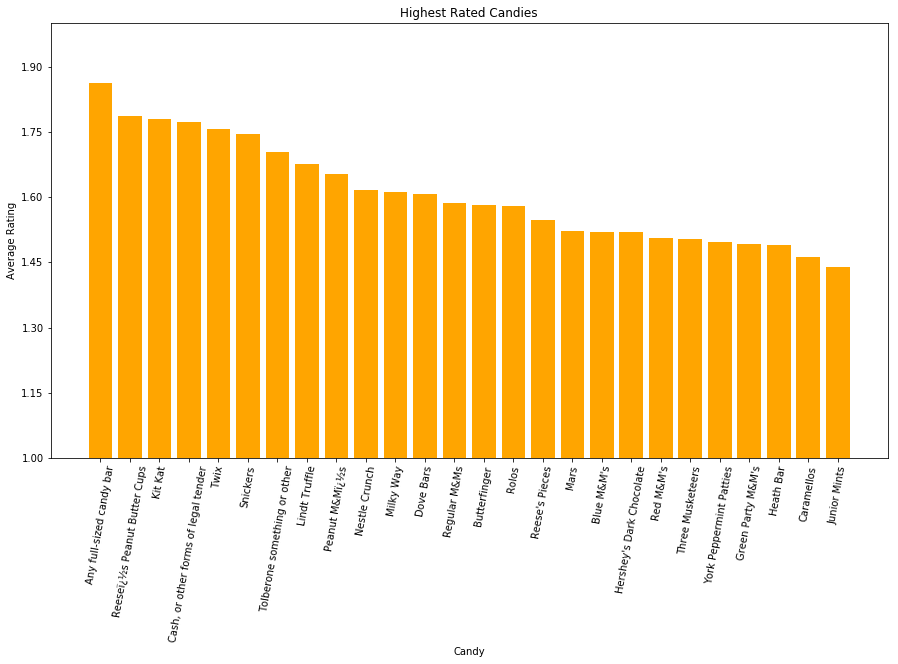

In [123]:
plt.figure(figsize=(15, 8))
plt.bar(top_25.candy, top_25.average, color = 'orange')
plt.xticks(rotation = 80)
plt.ylim(1, 2)
plt.yticks(np.arange(1, 1.92, step = .15))
plt.ylabel('Average Rating')
plt.xlabel('Candy')
plt.title('Highest Rated Candies');

In [124]:
# find bottom 25 percentile rated candies

bottom_25 = candy_avg[(candy_avg.average < 6.720907e-01) & (candy_avg.candy != 'Internal ID')]

In [125]:
# write a function that trims character length in candy column

def trim_names(candy):
    for c in candy:
        return candy[0:30]

In [126]:
# apply the function to the candy column to trim candy names to a reasonable length

bottom_25.candy = bottom_25.candy.apply(trim_names)

In [128]:
bottom_25 = bottom_25.sort_values('average', ascending = False)

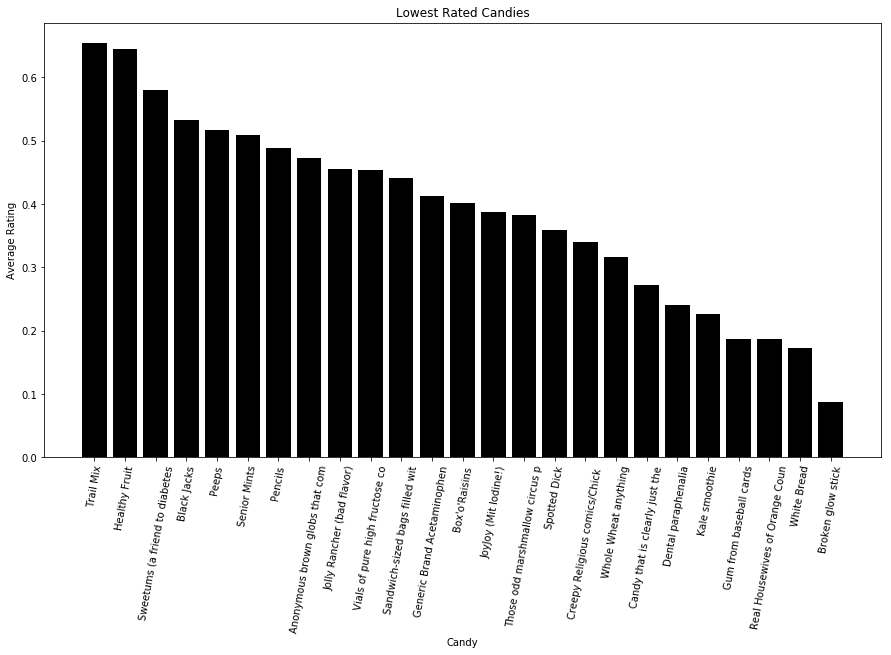

In [129]:
plt.figure(figsize=(15,8))
plt.bar(bottom_25.candy, bottom_25.average, color = 'black')
plt.xticks( rotation = 80)
plt.ylabel('Average Rating')
plt.xlabel('Candy')
plt.title('Lowest Rated Candies');

2. Let's look at candy preferences by age group 

In [130]:
# Merge the tables back together to match and candy preferences

all_qs = candy_questions.merge(other_questions, on="Internal ID")

# Convert AGE column to float 

all_qs.AGE = all_qs.AGE.astype(float)

# drop ID column

all_qs = all_qs.drop('Internal ID', axis = 1)

In [131]:
# Create age segments 

senior = all_qs[all_qs.AGE >= 60]
adult = all_qs[(all_qs.AGE > 30) & (all_qs.AGE < 60)]
young_adult = all_qs[(all_qs.AGE <= 30) & (all_qs.AGE >= 18)]
children = all_qs[all_qs.AGE < 18]

In [132]:
# Find average scores for senior and children segments

senior_avg = senior.mean()

children_avg = children.mean()

In [133]:
# Reset indexes and rename columns

senior_avg = senior_avg.reset_index()
children_avg = children_avg.reset_index()

senior_avg.columns = ['candy', 'average']
children_avg.columns = ['candy', 'average']

In [134]:
# drop nans 

senior_avg = senior_avg.dropna()
children_avg = children_avg.dropna()

In [136]:
# Find candies in each demographic whose ratings were in the 95th percentile

senior_95th = np.percentile(senior_avg.average, 95)
children_95th = np.percentile(children_avg.average, 95)

In [137]:
print(senior_95th, children_95th)

1.7023242412600843 1.7912499999999998


In [138]:
sen_candy = senior_avg[(senior_avg.average > senior_95th) & (senior_avg.candy != 'AGE')]
child_candy = children_avg[(children_avg.average > children_95th) & (children_avg.candy != 'AGE')]

In [139]:
sen_candy = sen_candy.sort_values('average', ascending = False)
child_candy = child_candy.sort_values('average', ascending = False)

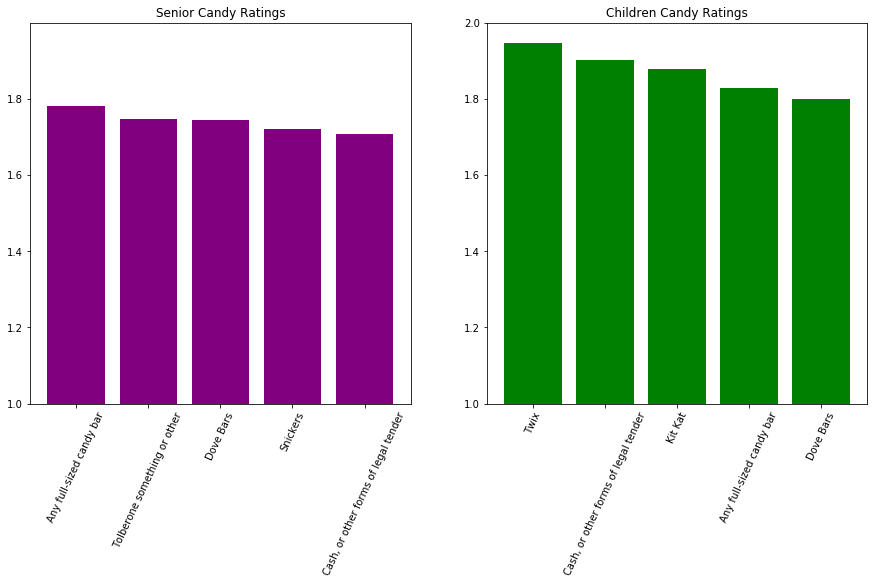

In [140]:
plt.subplots(2,2,figsize=(15,7))

plt.subplot(121)
plt.bar(sen_candy.candy, sen_candy.average, color = 'purple')
plt.xticks(rotation = 65)
plt.yticks(np.arange(1, 2, step=.2))
plt.ylim(1,2)
plt.title('Senior Candy Ratings')

plt.subplot(122)
plt.bar(child_candy.candy, child_candy.average, color = 'green')
plt.xticks(rotation=65)
plt.yticks(np.arange(1, 2.2, step=.2))
plt.ylim(1,2)
plt.title('Children Candy Ratings');


Interestingly, children tended to rate cash higher than seniors did, but both groups appreciated the value of a full-size candy bar or a Dove bar. Twix, the highest-rated candy by children, did not even make it into the senior top 5 percentile. Children also gave higher average ratings to their top candies than seniors. 